In [1]:
import pandas as pd
import numpy as np
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, KNNImputer

scale = StandardScaler()
label_encoder = LabelEncoder()

# Define the StratifiedKFold cross-validator
stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [2]:
logdb = pd.read_csv('https://raw.githubusercontent.com/lklewis83/StudentDBs/main/QTW_CS5/log2.csv')

# Set the display option to show more columns
pd.set_option('display.max_columns', None)

logdb.describe(include='all')

,Source Port,Destination Port,NAT Source Port,NAT Destination Port,Action,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
count,65532.000000,65532.000000,65532.000000,65532.000000,65532,6.553200e+04,6.553200e+04,6.553200e+04,6.553200e+04,65532.000000,65532.000000,65532.000000
unique,NaN,NaN,NaN,NaN,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,allow,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,37640,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,49391.969343,10577.385812,19282.972761,2671.049930,NaN,9.712395e+04,2.238580e+04,7.473815e+04,1.028660e+02,65.833577,41.399530,61.466505
std,15255.712537,18466.027039,21970.689669,9739.162278,NaN,5.618439e+06,3.828139e+06,2.463208e+06,5.133002e+03,302.461762,3218.871288,2223.332271
min,0.000000,0.000000,0.000000,0.000000,NaN,6.000000e+01,6.000000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
25%,49183.000000,80.000000,0.000000,0.000000,NaN,6.600000e+01,6.600000e+01,0.000000e+00,1.000000e+00,0.000000,1.000000,0.000000
50%,53776.500000,445.000000,8820.500000,53.000000,NaN,1.680000e+02,9.000000e+01,7.900000e+01,2.000000e+00,15.000000,1.000000,1.000000
75%,58638.000000,15000.000000,38366.250000,443.000000,NaN,7.522500e+02,2.100000e+02,4.490000e+02,6.000000e+00,30.000000,3.000000,2.000000


In [3]:
logdb.shape

(65532, 12)

In [4]:
logdb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65532 entries, 0 to 65531
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Source Port           65532 non-null  int64 
 1   Destination Port      65532 non-null  int64 
 2   NAT Source Port       65532 non-null  int64 
 3   NAT Destination Port  65532 non-null  int64 
 4   Action                65532 non-null  object
 5   Bytes                 65532 non-null  int64 
 6   Bytes Sent            65532 non-null  int64 
 7   Bytes Received        65532 non-null  int64 
 8   Packets               65532 non-null  int64 
 9   Elapsed Time (sec)    65532 non-null  int64 
 10  pkts_sent             65532 non-null  int64 
 11  pkts_received         65532 non-null  int64 
dtypes: int64(11), object(1)
memory usage: 6.0+ MB


# Visual EDA

<ipython-input-5-b5b0cdeff0f9>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='Action', data=logdb, order=logdb['Action'].value_counts().index, palette='viridis')  # Create the countplot


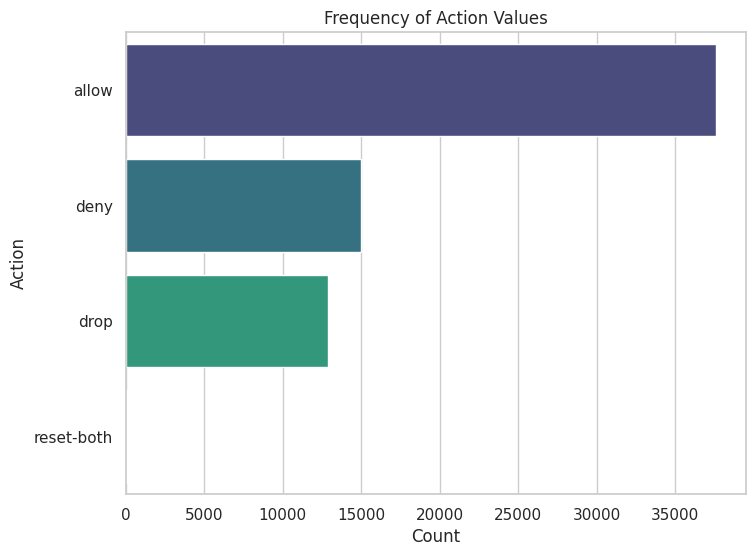

In [5]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Creating the plot for 'Action'
plt.figure(figsize=(8, 6))  # Define the figure size
sns.countplot(y='Action', data=logdb, order=logdb['Action'].value_counts().index, palette='viridis')  # Create the countplot
plt.title('Frequency of Action Values')  # Set the title of the plot
plt.xlabel('Count')  # Set the label for the x-axis
plt.ylabel('Action')  # Set the label for the y-axis

# Display the plot
plt.show()

<ipython-input-6-75e5282d41b5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='NAT Destination Port', jitter=0.1, palette='bright')  # jitter can be adjusted


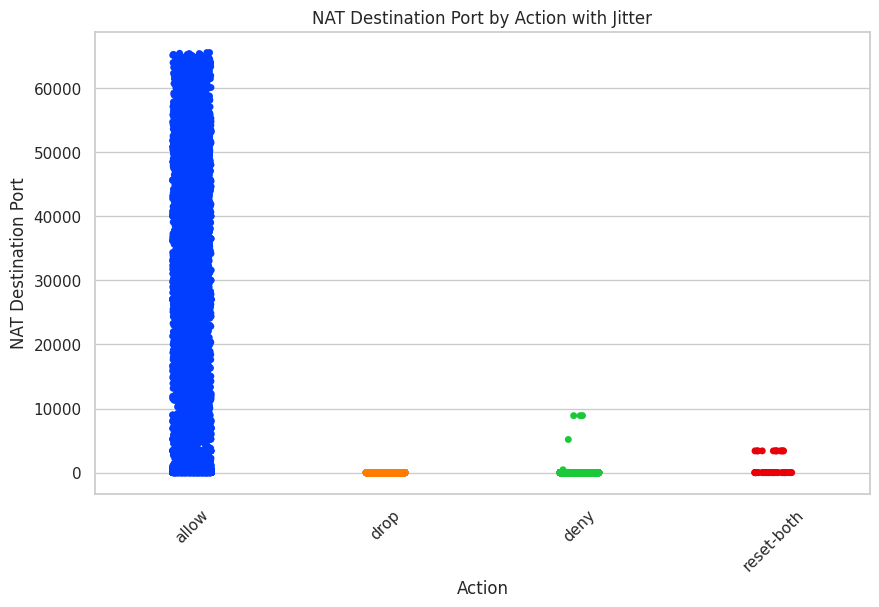

In [6]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='NAT Destination Port', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('NAT Destination Port by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('NAT Destination Port')
plt.xticks(rotation=45)
plt.show()

<ipython-input-7-c02465c6084c>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='Source Port', jitter=0.1, palette='bright')  # jitter can be adjusted


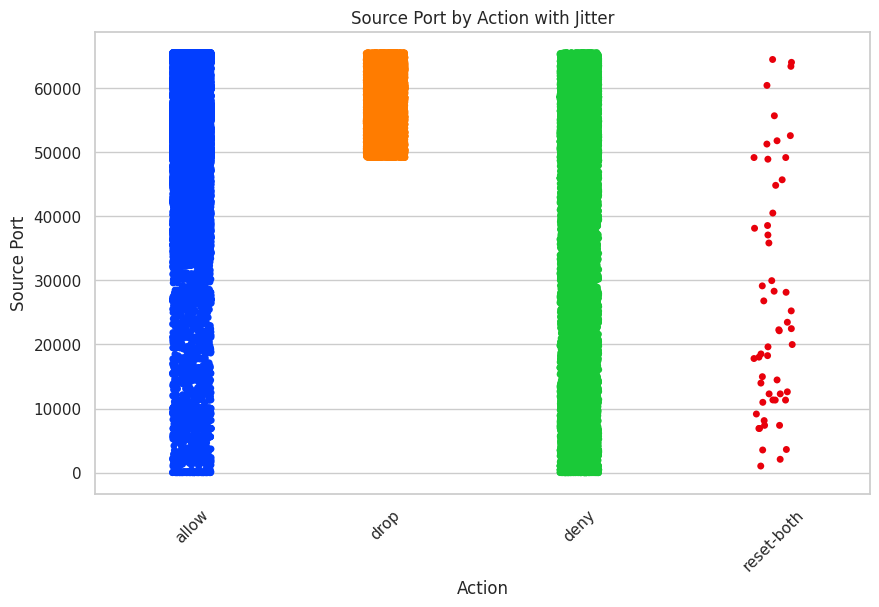

In [7]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='Source Port', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('Source Port by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('Source Port')
plt.xticks(rotation=45)
plt.show()

<ipython-input-8-348bc6361934>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='Destination Port', jitter=0.1, palette='bright')  # jitter can be adjusted


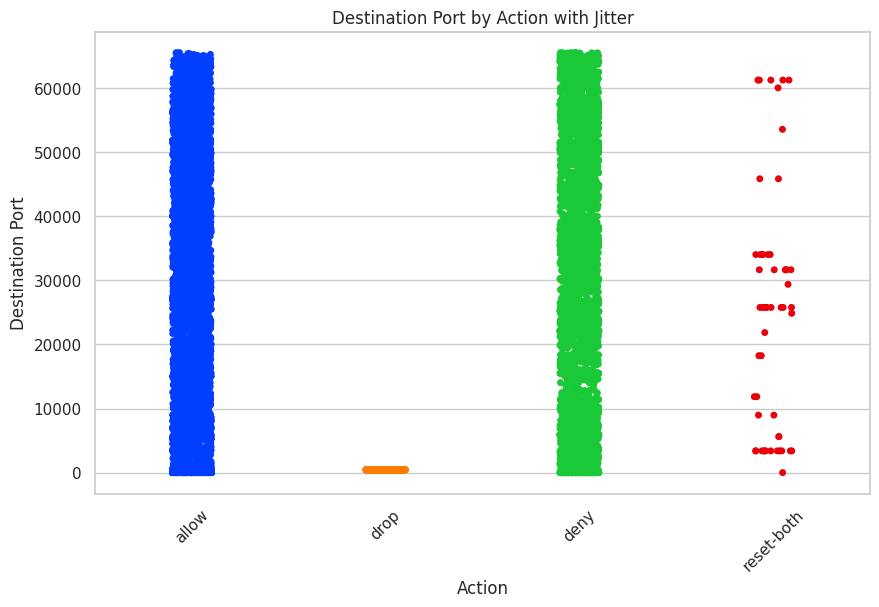

In [8]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='Destination Port', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('Destination Port by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('Destination Port')
plt.xticks(rotation=45)
plt.show()

<ipython-input-9-79fc0e5bae14>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='NAT Source Port', jitter=0.1, palette='bright')  # jitter can be adjusted


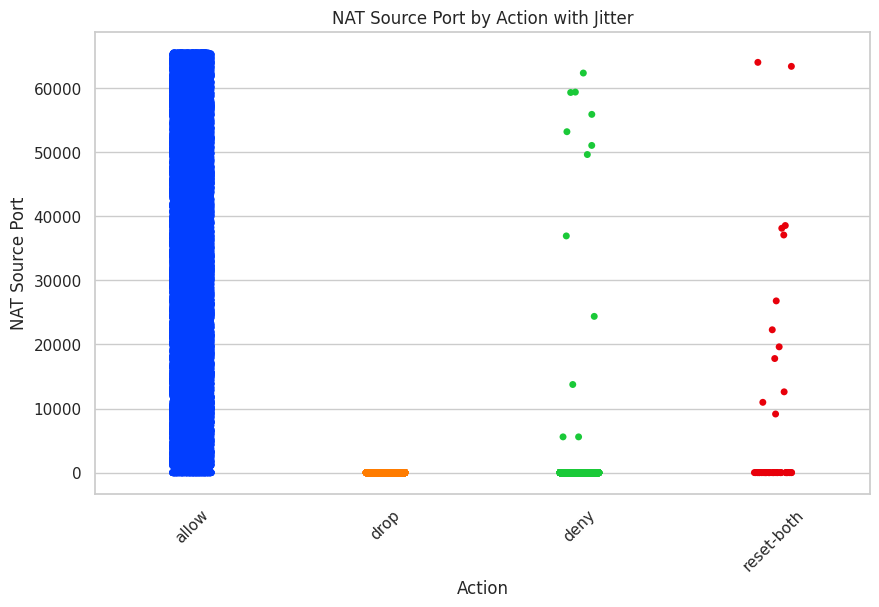

In [9]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='NAT Source Port', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('NAT Source Port by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('NAT Source Port')
plt.xticks(rotation=45)
plt.show()

<ipython-input-10-c428dadb64ee>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='Bytes', jitter=0.1, palette='bright')  # jitter can be adjusted


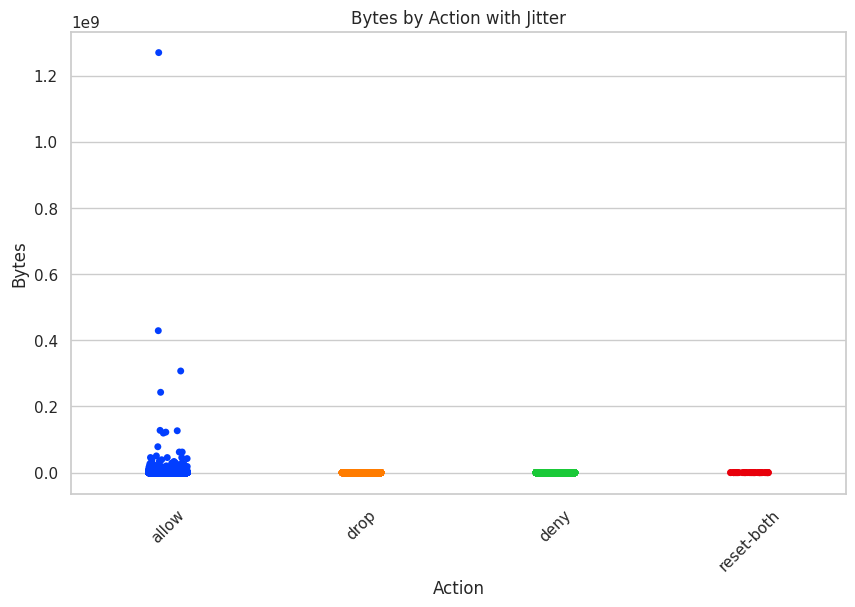

In [10]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='Bytes', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('Bytes by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('Bytes')
plt.xticks(rotation=45)
plt.show()

<ipython-input-11-4d130ebf41c5>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='Bytes Sent', jitter=0.1, palette='bright')  # jitter can be adjusted


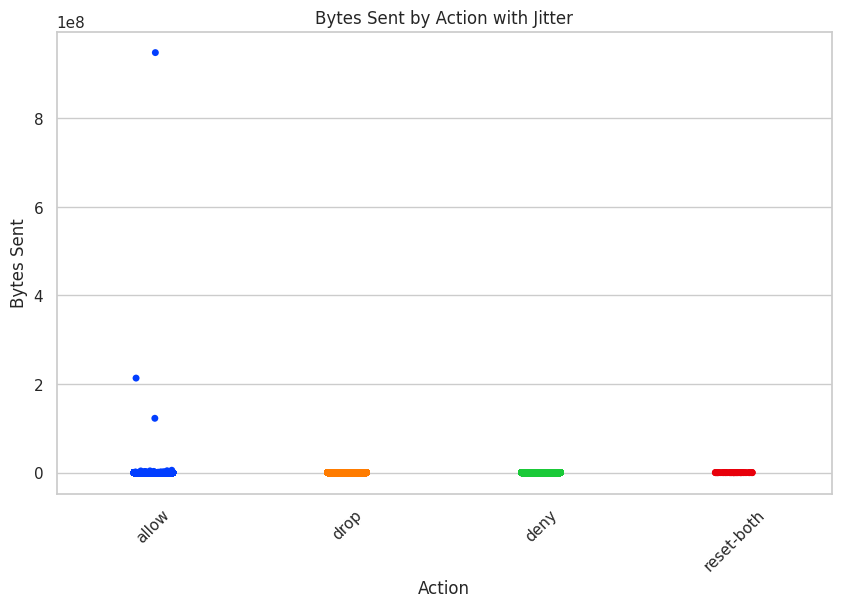

In [11]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='Bytes Sent', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('Bytes Sent by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('Bytes Sent')
plt.xticks(rotation=45)
plt.show()

<ipython-input-12-2565fbc33005>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='Bytes Received', jitter=0.1, palette='bright')  # jitter can be adjusted


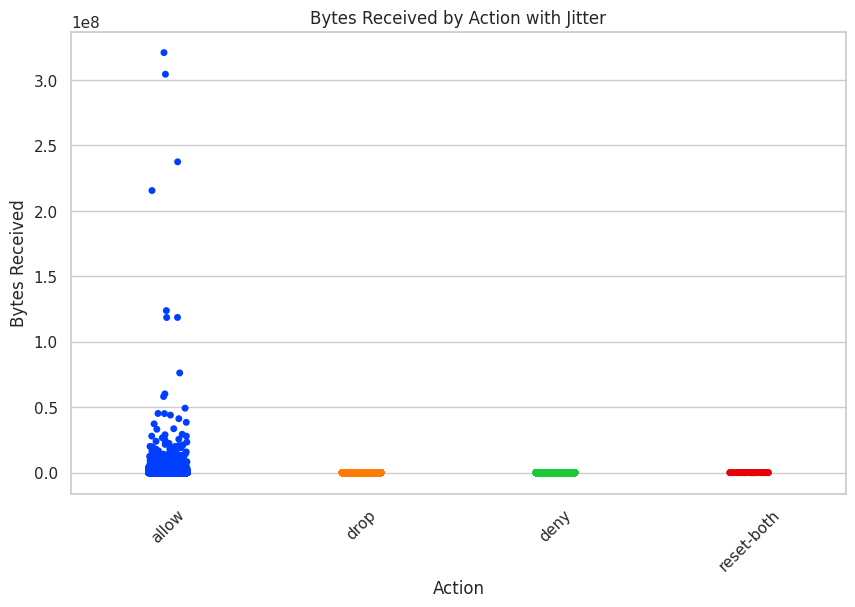

In [12]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='Bytes Received', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('Bytes Received by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('Bytes Received')
plt.xticks(rotation=45)
plt.show()

<ipython-input-13-56cd220f9366>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='Packets', jitter=0.1, palette='bright')  # jitter can be adjusted


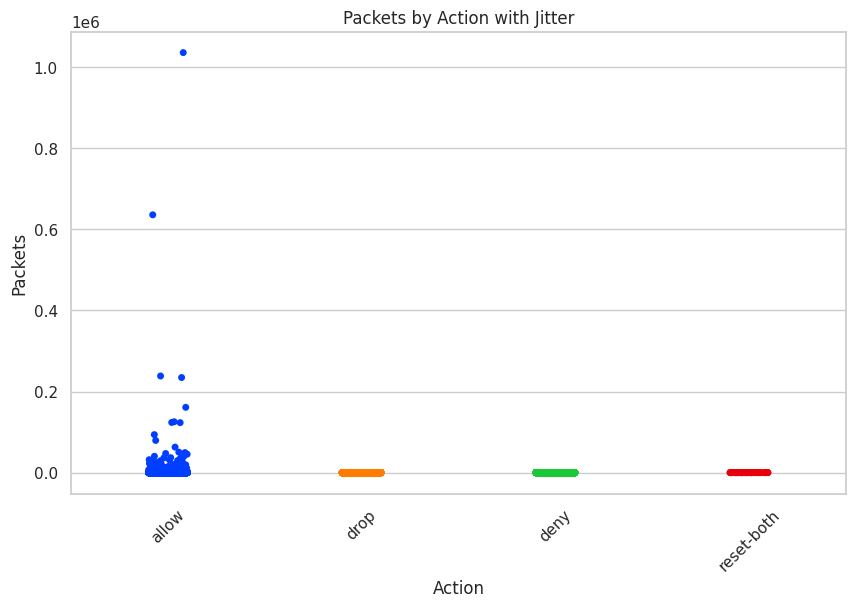

In [13]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='Packets', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('Packets by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('Packets')
plt.xticks(rotation=45)
plt.show()

<ipython-input-14-85e99bf4076e>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='Elapsed Time (sec)', jitter=0.1, palette='bright')  # jitter can be adjusted


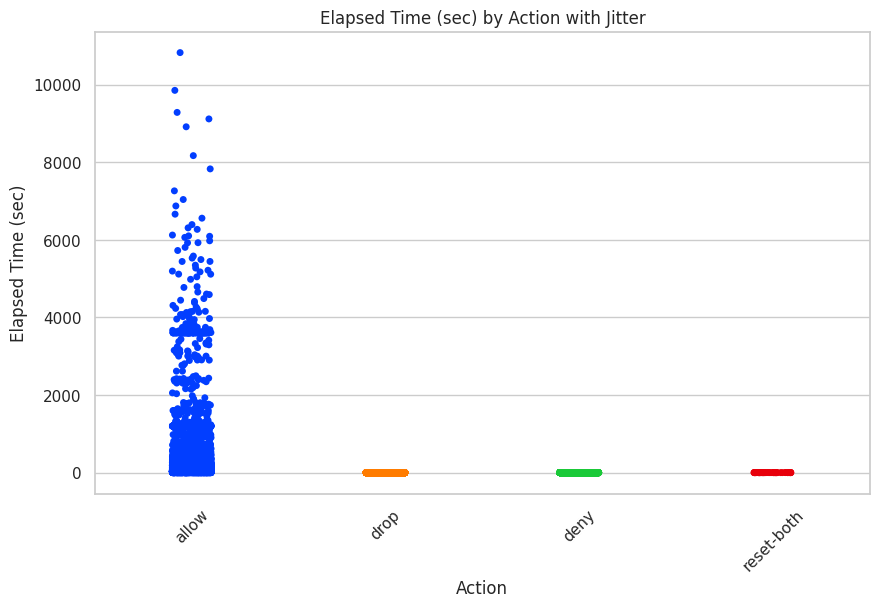

In [14]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='Elapsed Time (sec)', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('Elapsed Time (sec) by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('Elapsed Time (sec)')
plt.xticks(rotation=45)
plt.show()

<ipython-input-15-3fd376129992>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='pkts_sent', jitter=0.1, palette='bright')  # jitter can be adjusted


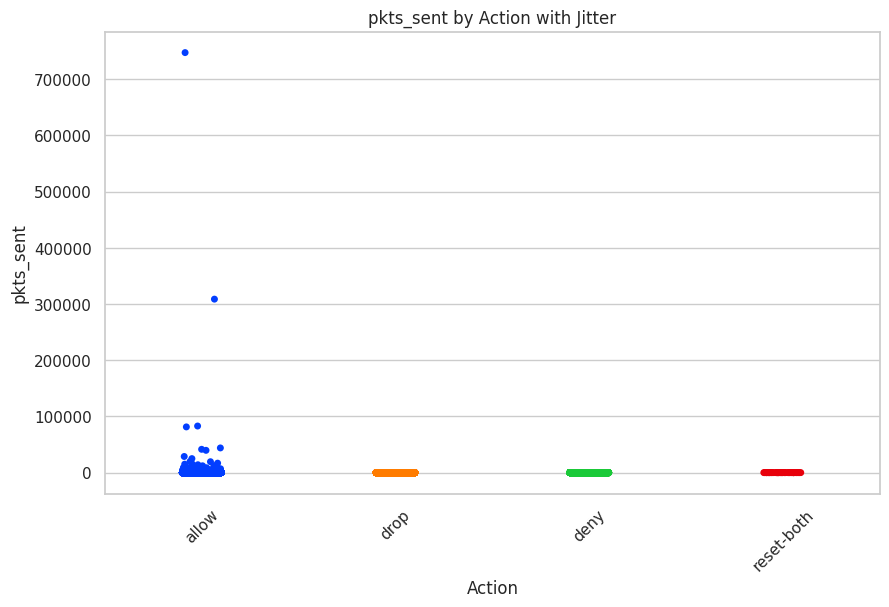

In [15]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='pkts_sent', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('pkts_sent by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('pkts_sent')
plt.xticks(rotation=45)
plt.show()

<ipython-input-16-a1d10ac4692f>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=logdb, x='Action', y='pkts_received', jitter=0.1, palette='bright')  # jitter can be adjusted


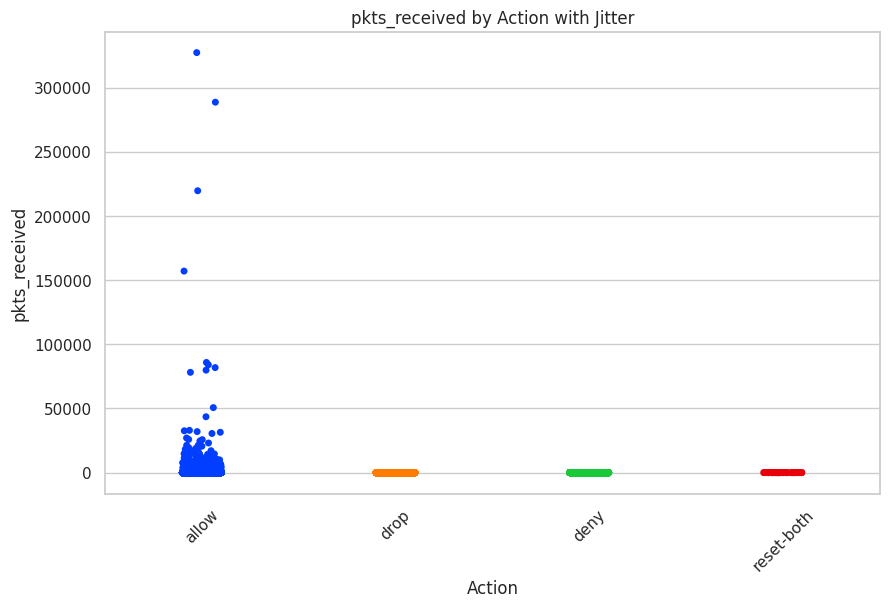

In [16]:
plt.figure(figsize=(10, 6))
sns.stripplot(data=logdb, x='Action', y='pkts_received', jitter=0.1, palette='bright')  # jitter can be adjusted
plt.title('pkts_received by Action with Jitter')
plt.xlabel('Action')
plt.ylabel('pkts_received')
plt.xticks(rotation=45)
plt.show()

# Impute Missing Values (0)

In [17]:
# Determine the numeric columns you want to impute
numeric_cols = logdb.select_dtypes(include=[np.number]).columns

# Replace 0 with NaN in the specified columns before imputation
logdb[numeric_cols] = logdb[numeric_cols].replace(0, pd.NA)

# Checking for missing values after replacement
missing_values_count = logdb.isna().sum()
print(missing_values_count)

Source Port               173
Destination Port          173
NAT Source Port         28432
NAT Destination Port    28432
Action                      0
Bytes                       0
Bytes Sent                  0
Bytes Received          31574
Packets                     0
Elapsed Time (sec)      28265
pkts_sent                   0
pkts_received           31574
dtype: int64


In [18]:
# Calculate the percentage of missing values for each column
missing_percentage = (logdb.isna().sum() / len(logdb)) * 100

# Print the percentage of missing values
print(missing_percentage)

Source Port              0.263993
Destination Port         0.263993
NAT Source Port         43.386437
NAT Destination Port    43.386437
Action                   0.000000
Bytes                    0.000000
Bytes Sent               0.000000
Bytes Received          48.181041
Packets                  0.000000
Elapsed Time (sec)      43.131600
pkts_sent                0.000000
pkts_received           48.181041
dtype: float64


### Impute using Mean

In [19]:
# Convert pd.NA to np.nan because SimpleImputer does not recognize pd.NA
logdb[['Source Port', 'Destination Port']] = logdb[['Source Port', 'Destination Port']].replace({pd.NA: np.nan})

# Initialize the SimpleImputer to replace missing values using the mean of each column
imputer = SimpleImputer(strategy='mean')

# Apply the imputer only to 'Source Port' and 'Destination Port' columns
logdb[['Source Port', 'Destination Port']] = imputer.fit_transform(logdb[['Source Port', 'Destination Port']])

# Print the updated data to check the changes
print(logdb[['Source Port', 'Destination Port']].head())

   Source Port  Destination Port
0      57222.0              53.0
1      56258.0            3389.0
2       6881.0           50321.0
3      50553.0            3389.0
4      50002.0             443.0


### Impute using KNN2

In [20]:
# Specify the columns with more missing values
columns_to_impute = ['NAT Source Port', 'NAT Destination Port']

# Convert pd.NA to np.nan in the specified columns
logdb[columns_to_impute] = logdb[columns_to_impute].replace({pd.NA: np.nan})

# Scaling the data may improve the performance of KNNImputer
scaler = StandardScaler()
logdb_scaled = scaler.fit_transform(logdb[columns_to_impute])
logdb_scaled = pd.DataFrame(logdb_scaled, columns=columns_to_impute)

# Initialize the KNNImputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=2, weights='distance')

# Apply the imputer to the selected columns
imputed_data = imputer.fit_transform(logdb_scaled)
logdb[columns_to_impute] = scaler.inverse_transform(imputed_data)  # Convert back to original scale if necessary

# Check the first few rows to confirm the imputation
print(logdb[columns_to_impute].head())

   NAT Source Port  NAT Destination Port
0          54587.0                  53.0
1          56258.0                3389.0
2          43265.0               50321.0
3          50553.0                3389.0
4          45848.0                 443.0


### Impute using KNN1

In [21]:
# Specify the columns with more missing values
columns_to_impute = ['Bytes Received', 'Elapsed Time (sec)', 'pkts_received']

# Convert pd.NA to np.nan in the specified columns
logdb[columns_to_impute] = logdb[columns_to_impute].replace({pd.NA: np.nan})

# Scaling the data may improve the performance of KNNImputer
scaler = StandardScaler()
logdb_scaled = scaler.fit_transform(logdb[columns_to_impute])
logdb_scaled = pd.DataFrame(logdb_scaled, columns=columns_to_impute)

# Initialize the KNNImputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=1, weights='distance')

# Apply the imputer to the selected columns
imputed_data = imputer.fit_transform(logdb_scaled)
logdb[columns_to_impute] = scaler.inverse_transform(imputed_data)  # Convert back to original scale if necessary

# Check the first few rows to confirm the imputation
print(logdb[columns_to_impute].head())

   Bytes Received  Elapsed Time (sec)  pkts_received
0            83.0                30.0            1.0
1          3168.0                17.0            9.0
2           120.0              1199.0            1.0
3          1889.0                17.0            7.0
4         18580.0                16.0           18.0


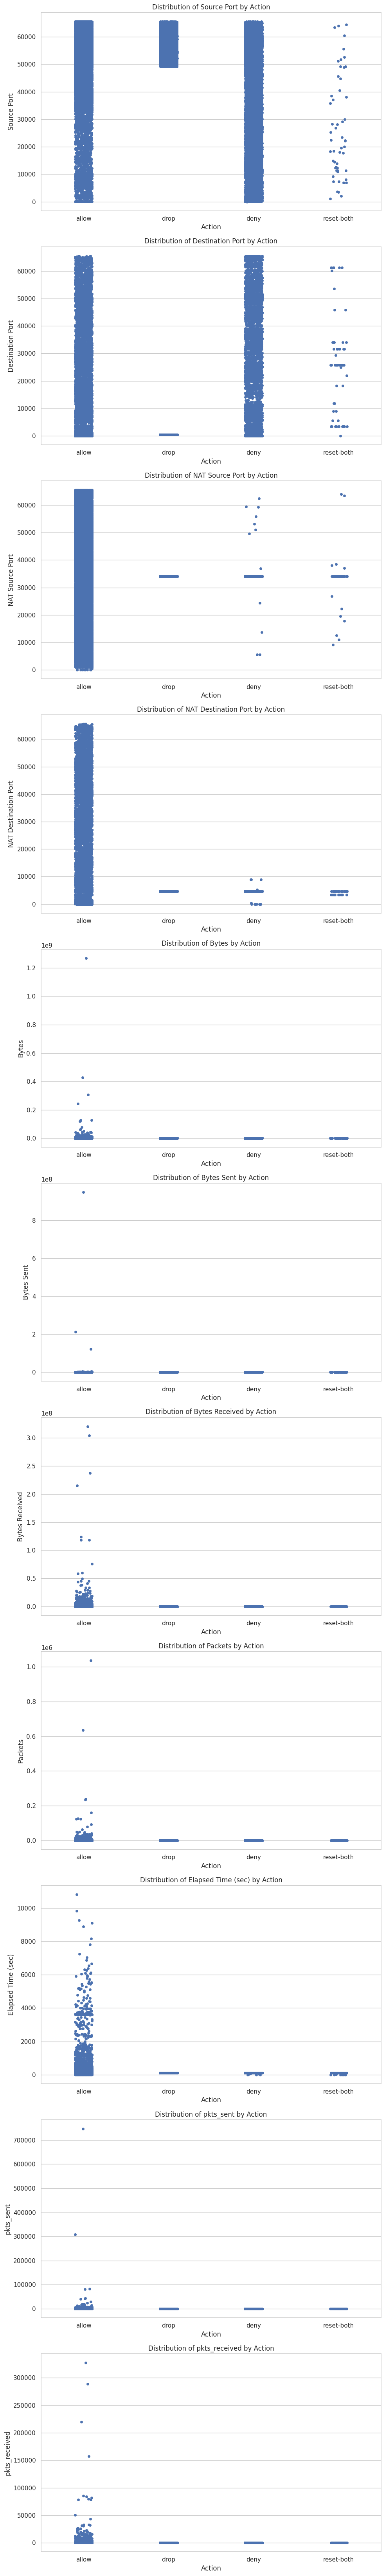

In [22]:
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Determine the numeric columns you want to plot; assuming these are the imputed ones
numeric_cols = logdb.select_dtypes(include=[np.number]).columns

# Creating a figure to hold the subplots
fig, axes = plt.subplots(len(numeric_cols), 1, figsize=(10, 6 * len(numeric_cols)))  # Adjust size as needed

# Loop through each numeric column and create a scatterplot with jitter
for i, col in enumerate(numeric_cols):
    sns.stripplot(x='Action', y=col, data=logdb, jitter=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Action')
    axes[i].set_xlabel('Action')
    axes[i].set_ylabel(col)

# Adjust the layout
plt.tight_layout()
plt.show()

# Scaled Attributes

In [23]:
# Apply scaling to the specified columns
scaled_columns = ['Bytes', 'Bytes Sent', 'Bytes Received', 'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received']
scaled_data = scale.fit_transform(logdb[scaled_columns])

# Create a new DataFrame with the scaled data
scaled_df = pd.DataFrame(scaled_data, columns=[col + '_' for col in scaled_columns])

# Merge the scaled attributes back into the original DataFrame
logdb = pd.concat([logdb, scaled_df], axis=1)

In [24]:
logdb.loc[:, ['Bytes_', 'Bytes Sent_', 'Bytes Received_', 'Packets_', 'Elapsed Time (sec)_', 'pkts_sent_', 'pkts_received_']]

,Bytes_,Bytes Sent_,Bytes Received_,Packets_,Elapsed Time (sec)_,pkts_sent_,pkts_received_
0,-0.017255,-0.005823,-0.055652,-0.019651,-0.286884,-0.012551,-0.050379
1,-0.016438,-0.005430,-0.054400,-0.016339,-0.330547,-0.009755,-0.046814
2,-0.017244,-0.005817,-0.055637,-0.019651,3.639462,-0.012551,-0.050379
3,-0.016695,-0.005472,-0.054919,-0.017118,-0.330547,-0.010376,-0.047705
4,-0.012773,-0.004077,-0.048142,-0.014001,-0.333906,-0.008823,-0.042803
...,...,...,...,...,...,...,...
65527,-0.017231,-0.005798,-0.055636,-0.018871,-0.337265,-0.011619,-0.049933
65528,0.815823,0.011736,1.817343,0.890740,-0.129024,0.293149,1.593649
65529,-0.017274,-0.005829,0.002871,-0.019845,0.001176,-0.012551,0.002038
65530,-0.017274,-0.005829,0.002871,-0.019845,0.001176,-0.012551,0.002038


In [25]:
logdb.loc[:, ['Bytes', 'Bytes Sent','Bytes Received','Packets','Elapsed Time (sec)', 'pkts_sent', 'pkts_received']]

,Bytes,Bytes Sent,Bytes Received,Packets,Elapsed Time (sec),pkts_sent,pkts_received
0,177,94,8.300000e+01,2,30.000000,1,1.000000
1,4768,1600,3.168000e+03,19,17.000000,10,9.000000
2,238,118,1.200000e+02,2,1199.000000,1,1.000000
3,3327,1438,1.889000e+03,15,17.000000,8,7.000000
4,25358,6778,1.858000e+04,31,16.000000,13,18.000000
...,...,...,...,...,...,...,...
65527,314,192,1.220000e+02,6,15.000000,4,2.000000
65528,4680740,67312,4.613428e+06,4675,77.000000,985,3690.000000
65529,70,70,1.442294e+05,1,115.764778,1,118.617793
65530,70,70,1.442294e+05,1,115.764778,1,118.617793


# Continous Attributes

In [26]:
print(logdb['Source Port'].unique())
print('--------------------')
print(logdb['Destination Port'].unique())
print('--------------------')
print(logdb['NAT Source Port'].unique())
print('--------------------')
print(logdb['NAT Destination Port'].unique())
print('--------------------')
print(logdb['Action'].unique())

[57222. 56258.  6881. ... 53518. 36226. 54871.]
--------------------
[   53.  3389. 50321. ... 47961. 32277. 22455.]
--------------------
[54587. 56258. 43265. ... 45052. 33275. 13485.]
--------------------
[   53.  3389. 50321. ...  4765. 47961. 32277.]
--------------------
['allow' 'drop' 'deny' 'reset-both']


Multiple Unqique values...proves these are continous variables

In [27]:
print(logdb['Source Port'].value_counts())
print('--------------------')
print(logdb['Destination Port'].value_counts())
print('--------------------')
print(logdb['NAT Source Port'].value_counts())
print('--------------------')
print(logdb['NAT Destination Port'].value_counts())
print('--------------------')
print(logdb['Action'].value_counts())

Source Port
58638.0    840
27005.0    513
443.0      273
57470.0    222
49418.0    210
          ... 
32996.0      1
60574.0      1
60570.0      1
65368.0      1
54871.0      1
Name: count, Length: 22724, dtype: int64
--------------------
Destination Port
53.0       15414
445.0      12891
443.0      11684
80.0        4035
25174.0     1087
           ...  
20009.0        1
48608.0        1
10016.0        1
13384.0        1
22455.0        1
Name: count, Length: 3273, dtype: int64
--------------------
NAT Source Port
34060.694636    28432
48817.000000       83
58638.000000       51
50116.000000       15
7986.000000         5
                ...  
2063.000000         1
33661.000000        1
36797.000000        1
14122.000000        1
13485.000000        1
Name: count, Length: 29152, dtype: int64
--------------------
NAT Destination Port
4718.038922     28432
53.000000       15094
443.000000      11678
80.000000        4028
27015.000000      234
                ...  
45561.000000        1
4

## Continous Groups

In [28]:
# Calculate the value counts for 'Source Port'
port_counts = logdb['Source Port'].value_counts()

# Initialize 'Source_Port_Groups' with the current 'Source Port' values
logdb['Source_Port_Groups'] = logdb['Source Port']

# HELP
logdb.loc[logdb['Source Port'].isin(port_counts[port_counts < 100].index), 'Source_Port_Groups'] = -1

# Verify the update
print(logdb['Source_Port_Groups'].value_counts())

Source_Port_Groups
-1.000000        62801
 58638.000000      840
 27005.000000      513
 443.000000        273
 57470.000000      222
 49418.000000      210
 6881.000000       177
 49522.705901      173
 50584.000000      116
 3478.000000       105
 26900.000000      102
Name: count, dtype: int64


In [29]:
# Calculate the value counts for 'Source Port'
port_counts = logdb['Destination Port'].value_counts()

# Initialize 'Source_Port_Groups' with the current 'Source Port' values
logdb['Destination_Port_Groups'] = logdb['Destination Port']

# Update 'Source_Port_Groups' to -1 where the port count is less than 200
logdb.loc[logdb['Destination Port'].isin(port_counts[port_counts < 710].index), 'Destination_Port_Groups'] = -1

# Verify the update
print(logdb['Destination_Port_Groups'].value_counts())

Destination_Port_Groups
-1.0        16446
 53.0       15414
 445.0      12891
 443.0      11684
 80.0        4035
 25174.0     1087
 5900.0       909
 37965.0      826
 22114.0      767
 64147.0      756
 50584.0      717
Name: count, dtype: int64


In [30]:
# Calculate the value counts for 'Source Port'
port_counts = logdb['NAT Source Port'].value_counts()

# Initialize 'Source_Port_Groups' with the current 'Source Port' values
logdb['NAT_Source_Port_Groups'] = logdb['NAT Source Port']

# Update 'Source_Port_Groups' to -1 where the port count is less than 200
logdb.loc[logdb['NAT Source Port'].isin(port_counts[port_counts < 5].index), 'NAT_Source_Port_Groups'] = -1

# Verify the update
print(logdb['NAT_Source_Port_Groups'].value_counts())

NAT_Source_Port_Groups
-1.000000        36916
 34060.694636    28432
 48817.000000       83
 58638.000000       51
 50116.000000       15
 7986.000000         5
 57880.000000        5
 43757.000000        5
 57596.000000        5
 60868.000000        5
 30399.000000        5
 14591.000000        5
Name: count, dtype: int64


In [31]:
# Calculate the value counts for 'Source Port'
port_counts = logdb['NAT Destination Port'].value_counts()

# Initialize 'Source_Port_Groups' with the current 'Source Port' values
logdb['NAT_Destination_Port_Groups'] = logdb['NAT Destination Port']

# Update 'Source_Port_Groups' to -1 where the port count is less than 200
logdb.loc[logdb['NAT Destination Port'].isin(port_counts[port_counts < 100].index), 'NAT_Destination_Port_Groups'] = -1

# Verify the update
print(logdb['NAT_Destination_Port_Groups'].value_counts())

NAT_Destination_Port_Groups
 4718.038922     28432
 53.000000       15094
 443.000000      11678
-1.000000         5351
 80.000000        4028
 27015.000000      234
 27017.000000      160
 3389.000000       156
 123.000000        156
 6881.000000       143
 5228.000000       100
Name: count, dtype: int64


## One Hot Encode the Target Value

In [32]:
# Display unique values in the 'Action' column
print("Unique actions before encoding:", logdb['Action'].unique())

Unique actions before encoding: ['allow' 'drop' 'deny' 'reset-both']


In [33]:
logdb['Action'].isna().sum()

0

In [34]:
# Define a dictionary that maps actions to integers
action_to_integer = {
    'allow': 0,
    'deny': 1,
    'drop': 2,
    'reset-both': 3
}

# Apply the mapping to the 'Action' column to create a new encoded column
logdb['Action_encoded'] = logdb['Action'].map(action_to_integer)

# Verify the encoding by displaying the unique values and their counts
print(logdb['Action_encoded'].value_counts())

Action_encoded
0    37640
1    14987
2    12851
3       54
Name: count, dtype: int64


In [35]:
# Determine the numeric columns you want to impute, excluding 'action_encoded'
numeric_cols = logdb.select_dtypes(include=[np.number]).drop(columns='Action_encoded').columns

# Replace 0 with NaN in the specified columns before imputation
logdb[numeric_cols] = logdb[numeric_cols].replace(0, pd.NA)

# Checking for missing values after replacement
logdb.isna().sum()

Source Port                    0
Destination Port               0
NAT Source Port                0
NAT Destination Port           0
Action                         0
Bytes                          0
Bytes Sent                     0
Bytes Received                 0
Packets                        0
Elapsed Time (sec)             0
pkts_sent                      0
pkts_received                  0
Bytes_                         0
Bytes Sent_                    0
Bytes Received_                0
Packets_                       0
Elapsed Time (sec)_            0
pkts_sent_                     0
pkts_received_                 0
Source_Port_Groups             0
Destination_Port_Groups        0
NAT_Source_Port_Groups         0
NAT_Destination_Port_Groups    0
Action_encoded                 0
dtype: int64

# Split Data

## Split Target

In [36]:
logdb['Action_encoded'].unique()

array([0, 2, 1, 3])

In [37]:
y = logdb['Action_encoded']

print(y.shape)

(65532,)


### Covert to Action to Integer

In [38]:
# Check the current type and unique values of y
print("Data type of y:", y.dtype)
print("Unique values in y:", np.unique(y))

# Round the float values to the nearest integer and convert to int type
y = np.round(y).astype(int)

# Check the new unique values to ensure they are integers suitable for classification
print("New unique values in y:", np.unique(y))


Data type of y: int64
Unique values in y: [0 1 2 3]
New unique values in y: [0 1 2 3]


In [39]:
y.value_counts()

Action_encoded
0    37640
1    14987
2    12851
3       54
Name: count, dtype: int64

## Split Dataset

In [40]:
# Define the list of columns to be included in the new DataFrame X
columns_to_include = [
    'Bytes_', 'Bytes Sent_', 'Bytes Received_', 'Packets_', 'Elapsed Time (sec)_', 'pkts_sent_', 'pkts_received_', 'Source_Port_Groups', 'Destination_Port_Groups',
    'NAT_Source_Port_Groups', 'NAT_Destination_Port_Groups'
]

# Select these columns from logdb to create the new DataFrame X
X = logdb[columns_to_include]

# Display the shape of the new DataFrame to verify it includes the correct columns
print(X.shape)

(65532, 11)


In [41]:
X

,Bytes_,Bytes Sent_,Bytes Received_,Packets_,Elapsed Time (sec)_,pkts_sent_,pkts_received_,Source_Port_Groups,Destination_Port_Groups,NAT_Source_Port_Groups,NAT_Destination_Port_Groups
0,-0.017255,-0.005823,-0.055652,-0.019651,-0.286884,-0.012551,-0.050379,-1.0,53.0,-1.000000,53.000000
1,-0.016438,-0.005430,-0.054400,-0.016339,-0.330547,-0.009755,-0.046814,-1.0,-1.0,-1.000000,3389.000000
2,-0.017244,-0.005817,-0.055637,-0.019651,3.639462,-0.012551,-0.050379,6881.0,-1.0,-1.000000,-1.000000
3,-0.016695,-0.005472,-0.054919,-0.017118,-0.330547,-0.010376,-0.047705,-1.0,-1.0,-1.000000,3389.000000
4,-0.012773,-0.004077,-0.048142,-0.014001,-0.333906,-0.008823,-0.042803,-1.0,443.0,-1.000000,443.000000
...,...,...,...,...,...,...,...,...,...,...,...
65527,-0.017231,-0.005798,-0.055636,-0.018871,-0.337265,-0.011619,-0.049933,-1.0,80.0,-1.000000,80.000000
65528,0.815823,0.011736,1.817343,0.890740,-0.129024,0.293149,1.593649,-1.0,80.0,-1.000000,80.000000
65529,-0.017274,-0.005829,0.002871,-0.019845,0.001176,-0.012551,0.002038,-1.0,445.0,34060.694636,4718.038922
65530,-0.017274,-0.005829,0.002871,-0.019845,0.001176,-0.012551,0.002038,-1.0,445.0,34060.694636,4718.038922


# SVC Model

## Basic Model

In [42]:
my_model = LinearSVC(C=1)

my_model.fit(X,y)

LinearSVC(C=1)

In [43]:
y_pred = my_model.predict(X)

In [44]:
accuracy_score(my_model.predict(X),y)

0.8358817066471342

### Confusion Matrix Basic Model

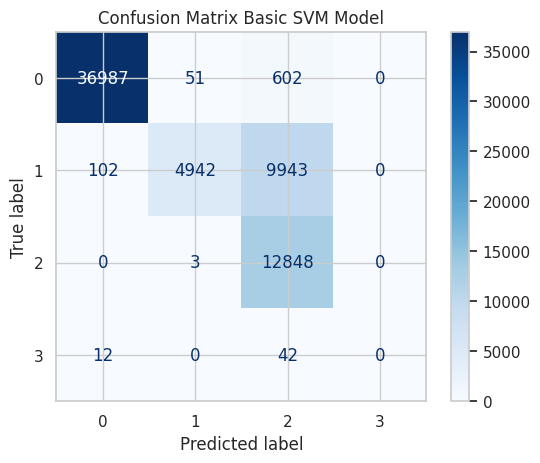

In [45]:
# Generate the confusion matrix
cm = confusion_matrix(y, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=my_model.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix Basic SVM Model')
plt.show()

### Cross validation of Basic SVM

In [46]:
cross_val_score(my_model, X, y, cv=stratified_cv, scoring='accuracy')

array([0.77927825, 0.79186694, 0.79291927, 0.79207996, 0.65054174])

## Improve Regularization
Help with normalizing the data.
Looking for when the model stops changing

In [47]:
my_model = LinearSVC(max_iter=100, tol=1e-4)  # Increase max_iter and adjust tol

best_C = None
highest_accuracy = 0

for i in [1E-10,1E-9,1E-8,1E-7,1E-6, 1E-5, 1E-4,1E-3]:
    my_model.C = i  # Set regularization parameter
    scores = cross_val_score(my_model, X, y, cv=stratified_cv, scoring='accuracy')
    mean_accuracy = scores.mean()
    std_dev = scores.std()
    print(f"C = {i}: Average accuracy = {mean_accuracy:.4f} with std = {std_dev:.4f}")

    # Update the best C if the current mean accuracy is higher than what was observed before
    if mean_accuracy > highest_accuracy:
        highest_accuracy = mean_accuracy
        best_C = i

# Print the best C value after the loop
print(f"The best C is {best_C} with an accuracy of {highest_accuracy:.4f}")

C = 1e-10: Average accuracy = 0.7708 with std = 0.0014
C = 1e-09: Average accuracy = 0.7724 with std = 0.0012
C = 1e-08: Average accuracy = 0.7721 with std = 0.0010
C = 1e-07: Average accuracy = 0.7072 with std = 0.0665
C = 1e-06: Average accuracy = 0.7659 with std = 0.0723
C = 1e-05: Average accuracy = 0.7511 with std = 0.0639
C = 0.0001: Average accuracy = 0.7596 with std = 0.0741
C = 0.001: Average accuracy = 0.7796 with std = 0.0740
The best C is 0.001 with an accuracy of 0.7796


Update the regularization to use the best option

In [48]:
my_new_model = LinearSVC(C=best_C, max_iter=100, tol=1e-4) # This iteration is my best iteration

my_new_model.fit(X,y)

LinearSVC(C=0.001, max_iter=100)

In [49]:
new_y_pred = my_new_model.predict(X)

In [50]:
accuracy_score(my_new_model.predict(X),y)

0.7150857596288835

#### Confusion Matrix Regularization

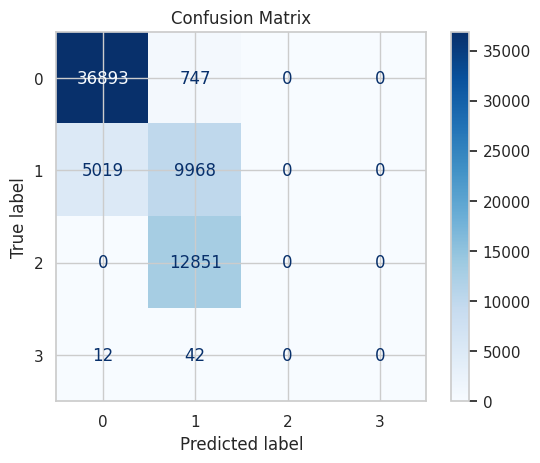

In [51]:
# Generate the confusion matrix
cm = confusion_matrix(y, new_y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=my_new_model.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix')
plt.show()

### Cross validation with Regularization

In [52]:
cross_val_score(my_new_model, X, y, cv=stratified_cv, scoring='accuracy')

array([0.82650492, 0.75928893, 0.82252403, 0.79192736, 0.76339081])

## Intercept scaling values

In [53]:
# Example intercept scaling values to iterate over
intercept_scalings = np.linspace(1, 10, 10)  # Example range from 1 to 10

best_accuracy = 0
best_intercept_scaling = None

# Iterate over the intercept scaling values
for intercept_scaling in intercept_scalings:
    # Initialize the model with the current intercept scaling
    model = LinearSVC(max_iter=100, tol=1e-4, intercept_scaling=intercept_scaling)

    # Measure the time to fit and evaluate the model using cross-validation
    scores = cross_val_score(model, X, y, cv=stratified_cv, scoring='accuracy')  # Use X and y directly
    average_accuracy = scores.mean()

    # Print results
    print(f"\nIntercept scaling: {intercept_scaling}")
    print(f"Average accuracy: {average_accuracy:.4f} with std deviation: {scores.std():.4f}")

    # Update best parameters if current model is better
    if average_accuracy > best_accuracy:
        best_accuracy = average_accuracy
        best_intercept_scaling = intercept_scaling

# Use the best intercept scaling found
print(f"\nBest intercept scaling: {best_intercept_scaling} with an accuracy of: {best_accuracy:.4f}")


Intercept scaling: 1.0
Average accuracy: 0.7721 with std deviation: 0.0664

Intercept scaling: 2.0
Average accuracy: 0.8104 with std deviation: 0.0181

Intercept scaling: 3.0
Average accuracy: 0.6911 with std deviation: 0.0941

Intercept scaling: 4.0
Average accuracy: 0.7320 with std deviation: 0.0871

Intercept scaling: 5.0
Average accuracy: 0.7832 with std deviation: 0.0120

Intercept scaling: 6.0
Average accuracy: 0.8182 with std deviation: 0.0120

Intercept scaling: 7.0
Average accuracy: 0.7173 with std deviation: 0.0906

Intercept scaling: 8.0
Average accuracy: 0.8039 with std deviation: 0.0270

Intercept scaling: 9.0
Average accuracy: 0.7742 with std deviation: 0.0729

Intercept scaling: 10.0
Average accuracy: 0.7848 with std deviation: 0.0767

Best intercept scaling: 6.0 with an accuracy of: 0.8182


In [54]:
model = LinearSVC(max_iter=100, tol=1e-4, intercept_scaling=best_intercept_scaling) # This iteration is my best iteration

model.fit(X,y)

accuracy_score(model.predict(X),y)

0.8305560642129036

### Confusion Matrix Intercept

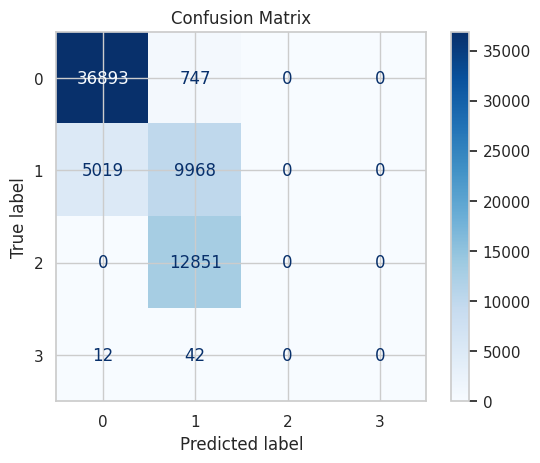

In [55]:
# Generate the confusion matrix
cm = confusion_matrix(y, new_y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix')
plt.show()

### Cross Validation with Intercept Sampling

In [56]:
cross_val_score(model, X, y, cv=stratified_cv, scoring='accuracy')

array([0.63775082, 0.79270619, 0.83480848, 0.82832291, 0.65130475])

## Update Tolerance

In [57]:
# Define the range of tolerance values to test
tolerances = [1e-7,1e-6,1e-5,1e-4, 1e-3, 1e-2,1e-1, 1]

# Initialize variables to keep track of the best tolerance
best_tol = None
best_accuracy = 0

# Loop over each tolerance value
for tol in tolerances:
    # Initialize the LinearSVC model with the current tolerance
    model = LinearSVC(max_iter=100, tol=tol, intercept_scaling=intercept_scaling, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=stratified_cv, scoring='accuracy')

    # Calculate the mean accuracy
    mean_accuracy = np.mean(scores)

    # Print the current tolerance and its accuracy
    print(f"Tolerance: {tol}, Cross-validated Accuracy: {mean_accuracy:.4f}")

    # Update the best parameters if the current model is better
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_tol = tol

# Output the best tolerance
print(f"Best Tolerance: {best_tol} with an Accuracy of: {best_accuracy:.4f}")

Tolerance: 1e-07, Cross-validated Accuracy: 0.7057
Tolerance: 1e-06, Cross-validated Accuracy: 0.7057
Tolerance: 1e-05, Cross-validated Accuracy: 0.7057
Tolerance: 0.0001, Cross-validated Accuracy: 0.7057
Tolerance: 0.001, Cross-validated Accuracy: 0.7057
Tolerance: 0.01, Cross-validated Accuracy: 0.7057
Tolerance: 0.1, Cross-validated Accuracy: 0.7057
Tolerance: 1, Cross-validated Accuracy: 0.7057
Best Tolerance: 1e-07 with an Accuracy of: 0.7057


In [58]:
# Fit the model with the best tolerance found
best_model = LinearSVC(max_iter=100, tol=best_tol, intercept_scaling=intercept_scaling, random_state=42)
best_model.fit(X, y)
predicted = best_model.predict(X)

# Calculate and print the accuracy on the training set
training_accuracy = accuracy_score(y, predicted)
print(f"Training Accuracy: {training_accuracy:.4f}")

Training Accuracy: 0.6419


### Confusion Matrix Tolerance

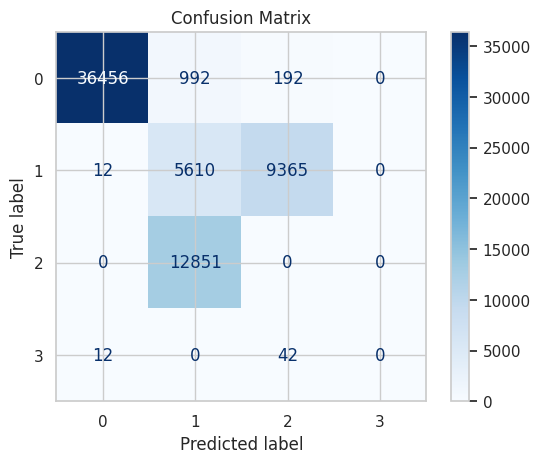

In [59]:
# Generate the confusion matrix
cm = confusion_matrix(y, predicted)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix')
plt.show()

### Cross Validation Tolerance

In [60]:
cross_val_score(best_model, X, y, cv=stratified_cv, scoring='accuracy')

array([0.63660639, 0.64972915, 0.75827865, 0.64611628, 0.83786052])

## Update Class Weights

In [61]:
# Define the range of class weights to test
class_weights = [
    None,  # Default, equal weighting
    'balanced',  # Automatically adjust weights inversely proportional to class frequencies
    {0: 1, 1: 10},  # Custom weights, example for binary classification
    {0: 1, 1: 50},  # More extreme example for binary classification
    # Add more custom weights as necessary
]

# Initialize variables to keep track of the best class weight
best_class_weight = None
best_accuracy = 0

# Loop over each class weight configuration
for class_weight in class_weights:
    # Initialize the LinearSVC model with the current class weight
    model = LinearSVC(max_iter=100, tol=1e-4, intercept_scaling=best_intercept_scaling,
                      class_weight=class_weight, random_state=42)

    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=stratified_cv, scoring='accuracy')

    # Calculate the average accuracy
    mean_accuracy = np.mean(scores)

    # Print the current class weight and its accuracy
    print(f"Class Weight: {class_weight}, Cross-validated Accuracy: {mean_accuracy:.4f}")

    # Update the best parameters if the current model is better
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_class_weight = class_weight

# Output the best class weight
print(f"Best Class Weight: {best_class_weight} with an Accuracy of: {best_accuracy:.4f}")

Class Weight: None, Cross-validated Accuracy: 0.7204
Class Weight: balanced, Cross-validated Accuracy: 0.7432
Class Weight: {0: 1, 1: 10}, Cross-validated Accuracy: 0.7903
Class Weight: {0: 1, 1: 50}, Cross-validated Accuracy: 0.7401
Best Class Weight: {0: 1, 1: 10} with an Accuracy of: 0.7903


In [62]:
# Fit the model with the best class weight found
new_best_model = LinearSVC(max_iter=100, tol=1e-4, intercept_scaling=best_intercept_scaling,
                      class_weight= {0: 1, 1: 10}, random_state=42)
new_best_model.fit(X, y)
new_predict = new_best_model.predict(X)


accuracy = accuracy_score(y, new_predict)
print(f"Accuracy with Best Class Weight: {accuracy:.4f}")

Accuracy with Best Class Weight: 0.7600


### Confusion Matrix Class Weights

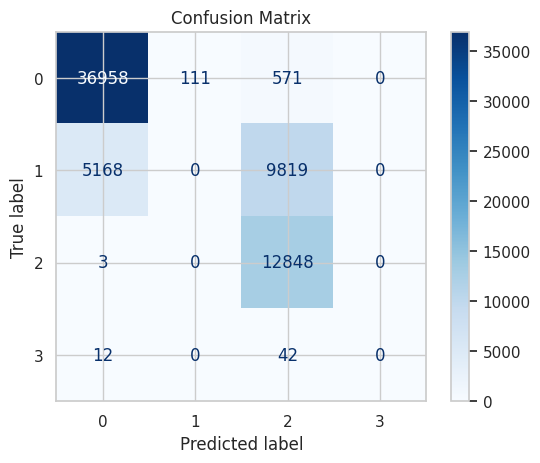

In [63]:
# Generate the confusion matrix
cm = confusion_matrix(y, new_predict)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=new_best_model.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix')
plt.show()

### Cross Validation Class weights

In [64]:
cross_val_score(new_best_model, X, y, cv=stratified_cv, scoring='accuracy')

array([0.82551308, 0.7785153 , 0.778651  , 0.77765909, 0.79131695])

# SGD Modeling

## SGD Model Splitting

In [65]:
# Split the data into 80% training and 20% testing with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

# Print the shapes of the outputs to verify the split
print("Training data shape (X_train):", X_train.shape)
print("Test data shape (X_test):", X_test.shape)
print("Training labels shape (y_train):", y_train.shape)
print("Test labels shape (y_test):", y_test.shape)


Training data shape (X_train): (52425, 11)
Test data shape (X_test): (13107, 11)
Training labels shape (y_train): (52425,)
Test labels shape (y_test): (13107,)


In [66]:
SGDmodel = SGDClassifier(loss = 'hinge')

# Fit the model on the training data
SGDmodel.fit(X_train, y_train)

# Predict on the testing data
SGD_predict = SGDmodel.predict(X_test)

# Calculate the accuracy on the testing data
accuracy = accuracy_score(y_test, SGD_predict)
print(f"Accuracy with SGD on test data: {accuracy:.4f}")

Accuracy with SGD on test data: 0.8267


## SGD Confusion Matrix

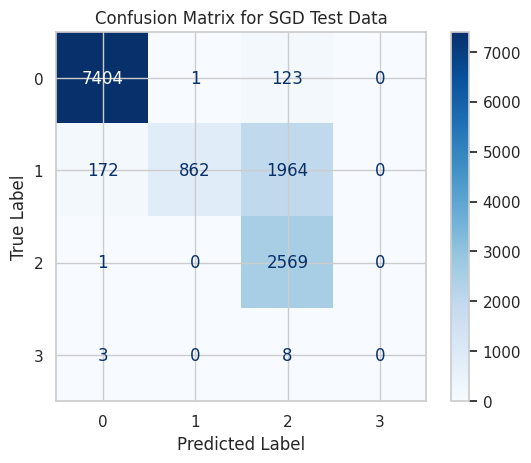

In [67]:
# Generate the confusion matrix using the test labels and predictions
cm = confusion_matrix(y_test, SGD_predict)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=SGDmodel.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix for SGD Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## TUNE SGD MODEL

In [68]:
# Sample parameter grids
learning_rates = ['optimal', 'invscaling', 'adaptive']
alphas = np.logspace(-4, -1, 4)  # Example range from 0.0001 to 0.1
etas = [0.01] if 'invscaling' in learning_rates or 'adaptive' in learning_rates else [None]

best_score = 0
best_params = {}

for rate in learning_rates:
    for alpha in alphas:
        for eta in etas:
            if rate == 'optimal' and eta is None:
                eta_use = 0.01  # Default for optimal which does not use eta0
            else:
                eta_use = eta

            model = SGDClassifier(loss='hinge', penalty='l2', max_iter=1000, tol=1e-4,
                                  learning_rate=rate, eta0=eta_use, alpha=alpha, random_state=42)
            try:
                scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
                mean_score = np.mean(scores)
                if mean_score > best_score:
                    best_score = mean_score
                    best_params = {'learning_rate': rate, 'alpha': alpha, 'eta0': eta_use}
            except Exception as e:
                print(f"An error occurred with learning_rate {rate}, alpha {alpha}, eta0 {eta_use}: {e}")

print("Best Score:", best_score)
print("Best Parameters:", best_params)

Best Score: 0.8261134954697187
Best Parameters: {'learning_rate': 'adaptive', 'alpha': 0.001, 'eta0': 0.01}


In [69]:
# Fit the model with the best parameters found
final_model = SGDClassifier(**best_params, random_state=42)
final_model.fit(X_train, y_train)

# Predict on the testing data
final_predict = final_model.predict(X_test)

# Calculate the accuracy on the testing data
accuracy = accuracy_score(y_test, final_predict)
print(f"Accuracy with SGD on test data: {accuracy:.4f}")

Accuracy with SGD on test data: 0.8423


### TUNE SGD CONFUSION MATRIX

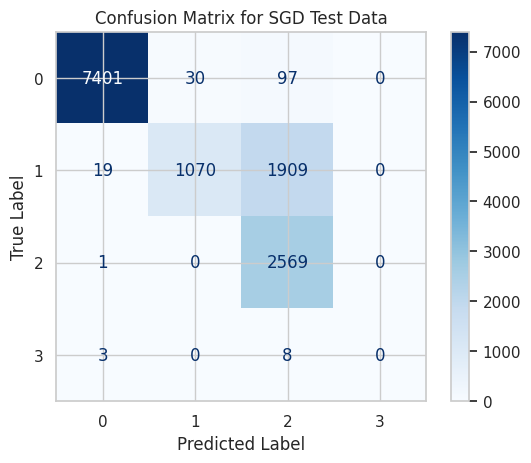

In [70]:
# Generate the confusion matrix using the test labels and predictions
cm = confusion_matrix(y_test, final_predict)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix for SGD Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## SGD Iterations and Early stopping

In [71]:
# Possible values for max_iter and early_stopping
max_iters = [500, 1000]
early_stoppings = [True, False]

best_score = 0
best_params = {}

for max_iter in max_iters:
    for early_stopping in early_stoppings:
        # Initialize the model with different max_iter and early_stopping
        model = SGDClassifier(loss='hinge', penalty='l2', max_iter=max_iter, tol=1e-4,
                              learning_rate='invscaling',  # Corrected key
                              eta0=0.01,  # Corrected key
                              alpha=.001,  # Corrected key
                              early_stopping=early_stopping,
                              random_state=42)

        # Fit the model on training data
        model.fit(X, y)

        # Predict on the testing data
        predictions = model.predict(X)

        # Calculate the accuracy on the testing data
        accuracy = accuracy_score(y, predictions)

        print(f"Testing with max_iter={max_iter}, early_stopping={early_stopping}")
        print(f"Accuracy: {accuracy:.4f}")

        # Update best parameters if current model is better
        if accuracy > best_score:
            best_score = accuracy
            best_params = {'max_iter': max_iter, 'early_stopping': early_stopping}

# Print best parameters
print("Best Score:", best_score)
print("Best Parameters:", best_params)

Testing with max_iter=500, early_stopping=True
Accuracy: 0.7246
Testing with max_iter=500, early_stopping=False
Accuracy: 0.7091
Testing with max_iter=1000, early_stopping=True
Accuracy: 0.7246
Testing with max_iter=1000, early_stopping=False
Accuracy: 0.7091
Best Score: 0.7245620460233169
Best Parameters: {'max_iter': 500, 'early_stopping': True}


In [72]:
# Fit the model with the best parameters found
final_model = SGDClassifier( max_iter=500,
                            early_stopping=True,
                            loss='hinge',
                            penalty='l2',
                            tol=1e-4,
                            learning_rate='invscaling',  # Corrected key
                            eta0=0.01,  # Corrected key
                            alpha=.001,
                            random_state=42)
final_model.fit(X_train, y_train)

# Predict on the testing data
final_predict = final_model.predict(X_test)

# Calculate the accuracy on the testing data
accuracy = accuracy_score(y_test, final_predict)
print(f"Accuracy with SGD on test data: {accuracy:.4f}")

Accuracy with SGD on test data: 0.7590


### SGD Iteration and Early Stopping Confusion Matrix

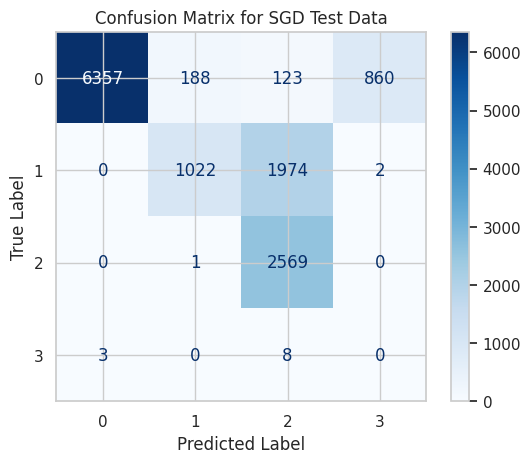

In [73]:
# Generate the confusion matrix using the test labels and predictions
cm = confusion_matrix(y_test, final_predict)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=final_model.classes_)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues)  # You can change the color map to any you prefer
plt.title('Confusion Matrix for SGD Test Data')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()